In [15]:
%matplotlib inline
import gudhi as gd
from gudhi import hera
import gudhi.representations.vector_methods
from gudhi import representations

import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import manifold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import kmedoids
import scipy.stats
import ndtest
import time

In [5]:
rng = np.random.default_rng(seed=42)

In [21]:
covs = [[[2.0, 1], [1, 1]]]#, [[1,1],[1,3]], [[4,1],[1,1]], [[1,1],[1,5]]]#, [[6,1],[1,1]]]
n_shapes = 5
n_samples = 100
samples = []

#for cov in covs:
#for i in range(0,n_samples):
#samples.append(rng.multivariate_normal(mean = [0, 0], cov = cov, size = n_samples))
        
for i in range(0,n_samples):
    samples.append(rng.normal(loc=1, scale = 1,size = (n_samples,2)))
                   
for i in range(0,n_samples):
    samples.append(rng.beta(a=1, b = 1,size = (n_samples,2)))

for i in range(0,n_samples):
    samples.append(rng.exponential(1,size = (n_samples,2)))

for i in range(0,n_samples):
    samples.append(rng.pareto(5,size = (n_samples,2)))     
        
for i in range(0,n_samples):
    samples.append(rng.uniform(0,2,size = (n_samples,2)))
    
#for i in range(0,n_samples):
#    samples.append(rng.standard_gamma(shape=1, size = (n_samples,2)))
y = [i//n_samples for i in range(0,n_shapes*n_samples)]

In [22]:
len(samples)

500

In [23]:
PD0s = []
PD1s = []
for s in samples:
    ac=gd.AlphaComplex(points = s)
    st = ac.create_simplex_tree()
    st.compute_persistence()
    PD0s.append(st.persistence_intervals_in_dimension(0))
    PD1s.append(st.persistence_intervals_in_dimension(1))
    

In [24]:
X_train, X_test, y_train, y_test = train_test_split(PD1s, y, test_size=0.4, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric = "precomputed")

/usr/local/lib64/python3.9/site-packages/gudhi-3.5.0rc1-py3.9-linux-x86_64.egg/gudhi/persistence_graphical_tools.py:510: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=cmap)


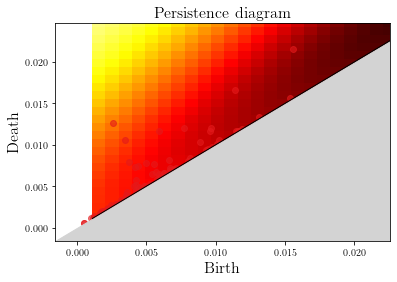

In [25]:
f,ax = plt.subplots()
gd.plot_persistence_density(PD1s[0], axes=ax)
gd.plot_persistence_diagram(PD1s[100], axes=ax)
plt.show()

In [26]:
tic = time.time()
W1D = gd.representations.WassersteinDistance(n_jobs=-1, order=1, internal_p =1)
W1D.fit(X_train)
W1_train = W1D.transform(X_train)
W1_test = W1D.transform(X_test)
print("1-Wasserstein done in ", time.time()-tic)
knn.fit(W1_train, y_train)
cv_scores = cross_val_score(knn, W1_train, y_train, cv=5)
print("1-Wasserstein training accuracy: ",np.mean(cv_scores))
score = knn.score(W1_test, y_test)
print("1-Wasserstein test accuracy: ",score)

1-Wasserstein done in  105.18345665931702
1-Wasserstein training accuracy:  0.8266666666666668
1-Wasserstein test accuracy:  0.85


In [27]:
mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(W1_train).embedding_

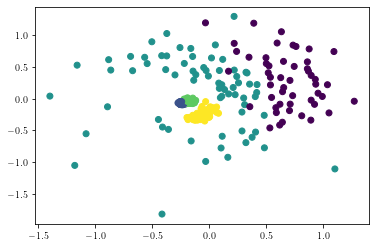

In [28]:
f,ax =plt.subplots()

ax.scatter(pos[:,0], pos[:,1], c= y_train)
    
#plt.legend()
plt.show()

In [29]:
W1D.fit(PD1s)
W1 = W1D.transform(PD1s)
W1D.fit(PD0s)
W0 = W1D.transform(PD0s)

Ws = W0+W1

In [30]:
in_cluster_dists = [[]]*n_shapes
for k in range(0,n_shapes):
    for i in range(100*k,100*k+100):
        for j in range(100*k, i):
            in_cluster_dists[k].append(Ws[i][j])
        
    print("Cluster #{}: avg distance within = {};  std = {}".format(k,np.mean(in_cluster_dists[k]),np.std(in_cluster_dists[k])))


Cluster #0: avg distance within = 1.9663030260764078;  std = 0.5766104126321318
Cluster #1: avg distance within = 1.0197286471110252;  std = 1.0306829096628587
Cluster #2: avg distance within = 1.7752308090787725;  std = 1.737569646632705
Cluster #3: avg distance within = 1.5094491324610404;  std = 1.6167340902016623
Cluster #4: avg distance within = 1.2655223550940087;  std = 1.5262445549016805


In [31]:
inter_cluster_dists = [[[]]*n_shapes]*n_shapes                   
                    

for l in range(0,n_shapes):
    for k in range(0,l):
        for i in range(0,100):
            for j in range(100*l, 100*l+i+1):
                inter_cluster_dists[l][k].append(Ws[100*k+i][j])
                #print((100*k+i,j))
                
        print("Between Cluster #{} and #{}: avg distance within = {};  std = {}".format(l,k,np.mean(inter_cluster_dists[l][k]),np.std(inter_cluster_dists[l][k])))

Between Cluster #1 and #0: avg distance within = 3.956847710317346;  std = 0.6674256939386176
Between Cluster #2 and #0: avg distance within = 3.778474285117518;  std = 1.4013697690822033
Between Cluster #2 and #1: avg distance within = 3.948632197961263;  std = 1.6562120972135432
Between Cluster #3 and #0: avg distance within = 3.8984124274390903;  std = 1.4821669829051212
Between Cluster #3 and #1: avg distance within = 3.2567661940842005;  std = 1.8633444521215854
Between Cluster #3 and #2: avg distance within = 3.36312822650116;  std = 1.8477793478111628
Between Cluster #4 and #0: avg distance within = 3.3798497235550347;  std = 1.7298173535049668
Between Cluster #4 and #1: avg distance within = 3.0526310173590097;  std = 1.8352223078232928
Between Cluster #4 and #2: avg distance within = 3.139720892382722;  std = 1.8378683697414235
Between Cluster #4 and #3: avg distance within = 2.941951699359818;  std = 1.8555208982980143


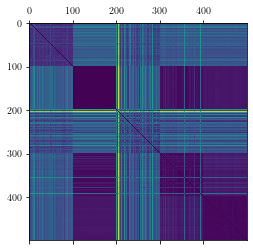

In [34]:
f,ax = plt.subplots()
ax.matshow(Ws)
plt.show()

In [35]:
ndtest.ks2d2s(samples[0][:,0],samples[0][:,1], samples[100][:,0],samples[100][:,1])
pvals = np.zeros((len(samples), len(samples)))
for i in range(0,len(samples)):
    for j in range(0,len(samples)):
        pvals[i][j] = ndtest.ks2d2s(samples[i][:,0],samples[i][:,1], samples[j][:,0],samples[j][:,1])


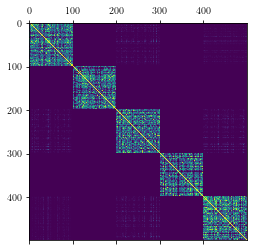

In [36]:
f,ax=plt.subplots()
ax.matshow(pvals)
plt.show()